In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("spam.csv", usecols=['v1','v2'])
df['label'] = df['v1'].map({'ham': 0, 'spam': 1})


In [3]:
display(df)

,v1,v2,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1
5568,ham,Will �_ b going to esplanade fr home?,0
5569,ham,"Pity, * was in mood for that. So...any other s...",0
5570,ham,The guy did some bitching but I acted like i'd...,0


# Data clean

#### Class imbalance 

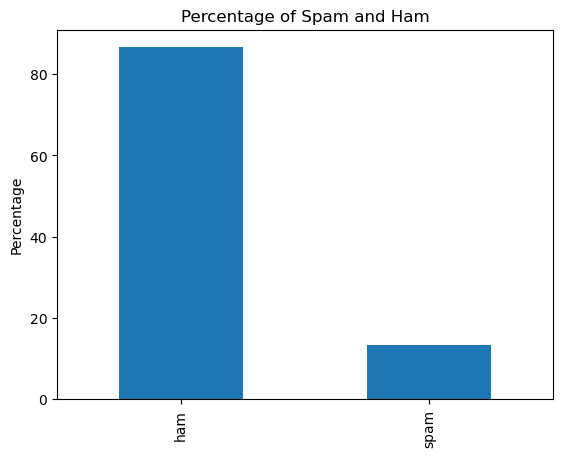

In [4]:
value_counts_percent = df['v1'].value_counts(normalize=True) * 100

# Plot the bar graph
value_counts_percent.plot(kind='bar')
plt.ylabel('Percentage')
plt.title('Percentage of Spam and Ham')
plt.show()

##### Downsampling and Upweighting

In [5]:
df_majority = df[df.label==0]
df_minority = df[df.label==1]

df_majority_downsampled = df_majority.sample(n=len(df_minority), replace=False, random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced['v2'], df_balanced['label'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

class_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(np.unique(class_weights))}

model = Sequential([
    Dense(128, input_dim=X_train_tfidf.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_tfidf.toarray(), y_train, epochs=3, batch_size=32, validation_split=0.1, class_weight=class_weight_dict)

loss, accuracy = model.evaluate(X_test_tfidf.toarray(), y_test)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Epoch 1/3
34/34 [==============================] - 2s 15ms/step - loss: 0.6585 - accuracy: 0.6298 - val_loss: 0.5560 - val_accuracy: 0.9167
Epoch 2/3
34/34 [==============================] - 0s 8ms/step - loss: 0.3287 - accuracy: 0.9833 - val_loss: 0.1699 - val_accuracy: 0.9750
Epoch 3/3
10/10 [==============================] - 0s 3ms/step - loss: 0.0977 - accuracy: 0.9632
Model Accuracy: 96.32%


In [15]:
def predict_spam_or_ham(model, vectorizer, sentence):
    sentence_tfidf = vectorizer.transform([sentence])
    
    spam_probability = model.predict(sentence_tfidf.toarray())[0][0]
    ham_probability = 1 - spam_probability 
    
    print(f"The given message is {spam_probability * 100:.2f}% likely to be spam and {ham_probability * 100:.2f}% likely to be ham.")
    
sentence = "I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."
predict_spam_or_ham(model, vectorizer, sentence)


1/1 [==============================] - 0s 33ms/step
The given message is 0.38% likely to be spam and 99.62% likely to be ham.
